# Bitcoin analysis based on historical data using Pyspark 

**Goals**:
1. Importing Bitcoin Historical dataset to Spark.
2. Performing analysis by Linear Regression
3. Present/Visualize your results.


# Columns

**Timestamp** -> Date (in Epoch Unix format) of data collection; It will later be transformed into a "human" date for better understanding; Intervals of approximately 1 in 1 minute, with time zone set to UTC.

**Open** -> Initial currency trading value in that measurement range, in USD.

**High** -> Highest value reached by the asset during that measurement interval, in USD.

**Low** -> Lowest value reached by the asset during that measurement interval, in USD.

**Close** -> Value of the asset at the time of closing the measurement range, in USD.

**Volume** -> Volume, in BTC, traded on Bitstamp during a given measurement interval

# Import required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Creating the Spark Session

In [4]:
spark_session = SparkSession.builder\
        .master("spark://192.168.2.251:7077") \
        .appName("Lecture2_Example3_bitcoin_trend_analysis")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 8)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .config("spark.yarn.executor.memoryOverhead", 600)\
        .getOrCreate()

sqlContext = SQLContext(spark_session.sparkContext)
spark_session.sparkContext.setLogLevel("ERROR")

25/02/09 18:03:11 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/02/09 18:03:11 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/09 18:03:12 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'spark.executor.memoryOverhead' instead.
25/02/09 18:03:12 WARN SparkConf: The configuration key 'spark.yarn.executor.memoryOverhead' has been deprecated as of Spark 2.3 and may be removed in the future. Please use the new key 'sp

# Performing Spark commands using Pyspark

In [5]:
#Loading Data to dataframe, store in cache memory to increase speed
df = sqlContext.read.csv("hdfs://192.168.2.251:9000/data/others/btcusd_1-min_data.csv",
                        header="true", inferSchema="true").cache()

In [6]:
# To use ANSI SQL query similar to RDBMS, you need to create a temporary table
df.createOrReplaceTempView("bitstampUSD") #creating a temp view table
bitstampUSD = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitstampUSD")
bitstampUSD = bitstampUSD.dropna("any") # Removing NA values
bitstampUSD = bitstampUSD.withColumnRenamed("Close", "Closing_Price").withColumnRenamed("Open", "Opening_Price")

# Feature Engineering/Extraction
**Use a VectorAssembler to put features into a feature vector column**

We have generated enough information post preprocessing our data to feed it to the model.
All missing values, zero values have been excluded from the data set.
Next we will normalize our data (as minimize the ranges between Min and max values).

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [8]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=["Opening_Price", "High", "Low", "Closing_Price", "Volume"], outputCol="features")
assembled_df = assembler.transform(bitstampUSD)
assembled_df.show(10, truncate= False)

[Stage 2:===================================================>       (7 + 1) / 8]

+------------+-------------+----+----+-------------+------+-------------------+-------------------------+
|Timestamp   |Opening_Price|High|Low |Closing_Price|Volume|dateTime           |features                 |
+------------+-------------+----+----+-------------+------+-------------------+-------------------------+
|1.32541206E9|4.58         |4.58|4.58|4.58         |0.0   |2012-01-01 10:01:00|[4.58,4.58,4.58,4.58,0.0]|
|1.32541212E9|4.58         |4.58|4.58|4.58         |0.0   |2012-01-01 10:02:00|[4.58,4.58,4.58,4.58,0.0]|
|1.32541218E9|4.58         |4.58|4.58|4.58         |0.0   |2012-01-01 10:03:00|[4.58,4.58,4.58,4.58,0.0]|
|1.32541224E9|4.58         |4.58|4.58|4.58         |0.0   |2012-01-01 10:04:00|[4.58,4.58,4.58,4.58,0.0]|
|1.3254123E9 |4.58         |4.58|4.58|4.58         |0.0   |2012-01-01 10:05:00|[4.58,4.58,4.58,4.58,0.0]|
|1.32541236E9|4.58         |4.58|4.58|4.58         |0.0   |2012-01-01 10:06:00|[4.58,4.58,4.58,4.58,0.0]|
|1.32541242E9|4.58         |4.58|4.58|4.58    

The result displays that the features have transformed into a Dense Vector.

# Normalization

Now we can scale the data using Min_Max_Scaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "scaled_features".

In [9]:
# Initialize the `Min_Max_scaler`
Min_Max_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
# Fit the DataFrame to the scaler
scaled_df= Min_Max_scaler.fit(assembled_df).transform(assembled_df)
# Inspect the result
scaled_df.select("features", "scaled_features").show(10, truncate=False)
scaled_df.columns

+-------------------------+-----------------------------------------------------------------------------------------+
|features                 |scaled_features                                                                          |
+-------------------------+-----------------------------------------------------------------------------------------+
|[4.58,4.58,4.58,4.58,0.0]|[7.159759946099862E-6,7.154243658863652E-6,7.170949930221143E-6,7.158839974228178E-6,0.0]|
|[4.58,4.58,4.58,4.58,0.0]|[7.159759946099862E-6,7.154243658863652E-6,7.170949930221143E-6,7.158839974228178E-6,0.0]|
|[4.58,4.58,4.58,4.58,0.0]|[7.159759946099862E-6,7.154243658863652E-6,7.170949930221143E-6,7.158839974228178E-6,0.0]|
|[4.58,4.58,4.58,4.58,0.0]|[7.159759946099862E-6,7.154243658863652E-6,7.170949930221143E-6,7.158839974228178E-6,0.0]|
|[4.58,4.58,4.58,4.58,0.0]|[7.159759946099862E-6,7.154243658863652E-6,7.170949930221143E-6,7.158839974228178E-6,0.0]|
|[4.58,4.58,4.58,4.58,0.0]|[7.159759946099862E-6,7.15424

['Timestamp',
 'Opening_Price',
 'High',
 'Low',
 'Closing_Price',
 'Volume',
 'dateTime',
 'features',
 'scaled_features']

# Building A Machine Learning Model With Spark ML

As we have finished the preprocessing of our data, now we build our Linear Regression model. We first need to split the data into train and test sets, using the randomSplit() method:

In [10]:
# Split the data into train,test and Validation sets
train_data, test_data = scaled_df.randomSplit([.7,.3], seed=rnd_seed)

**Now we create an ElacticNet Linear Regression Model**

ElasticNet is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of l1 and l2 using the l1_ratio parameter.
Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.
Source: https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [11]:
# Initialize `lr`
lr = (LinearRegression(featuresCol="scaled_features" , labelCol="Closing_Price", predictionCol="Predicted_price", 
                               maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [12]:
# Fit the data to the model
linearModel = lr.fit(train_data)

**Generate Predictions**

In [13]:
# Generate predictions
predictions = linearModel.transform(test_data)
# Select the columns and store in a variable
pred_data= predictions.select("Predicted_price", "Closing_Price").show(20)

[Stage 12:>                                                         (0 + 1) / 1]

+-----------------+-------------+
|  Predicted_price|Closing_Price|
+-----------------+-------------+
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
|5.849463393248722|         4.58|
+-----------------+-------------+
only showing top 20 rows



**Inspect the Metrics**

Now we look at some metrics to get a better idea of how good the model is performing actually. We will use Regression Evaluator and LinearRegressionModel.summary attribute to pull up the rootMeanSquaredError.
The rMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an rMSE value, the closer predicted and observed values are.

In [14]:
# Select (predicted_price, Weighted_price label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Closing_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

[Stage 13:====================================>                     (5 + 3) / 8]

Root Mean Squared Error (RMSE) on test data = 11.2429


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

MAE: 4.762558307920851


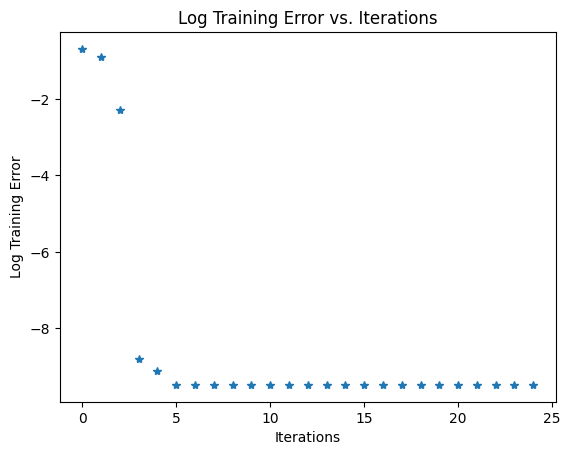

In [16]:
#Inspect and Model the metrics and Coefficient and Visualize the log of the training error as a function of iteration. 
#The scatter plot visualizes the logarithm of the training error for all 10 iterations.

iterations = list(range(0,linearModel.summary.totalIterations + 1))
lossHistory = np.log(linearModel.summary.objectiveHistory)
plt.plot(iterations,lossHistory,"*")
plt.title("Log Training Error vs. Iterations")
plt.ylabel("Log Training Error")
plt.xlabel("Iterations")
# Intercept for the model
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

In [17]:
pred_results=linearModel.evaluate(test_data)
Y = pred_results.predictions.select("Closing_Price").toPandas()
_Y = pred_results.predictions.select("Predicted_price").toPandas()

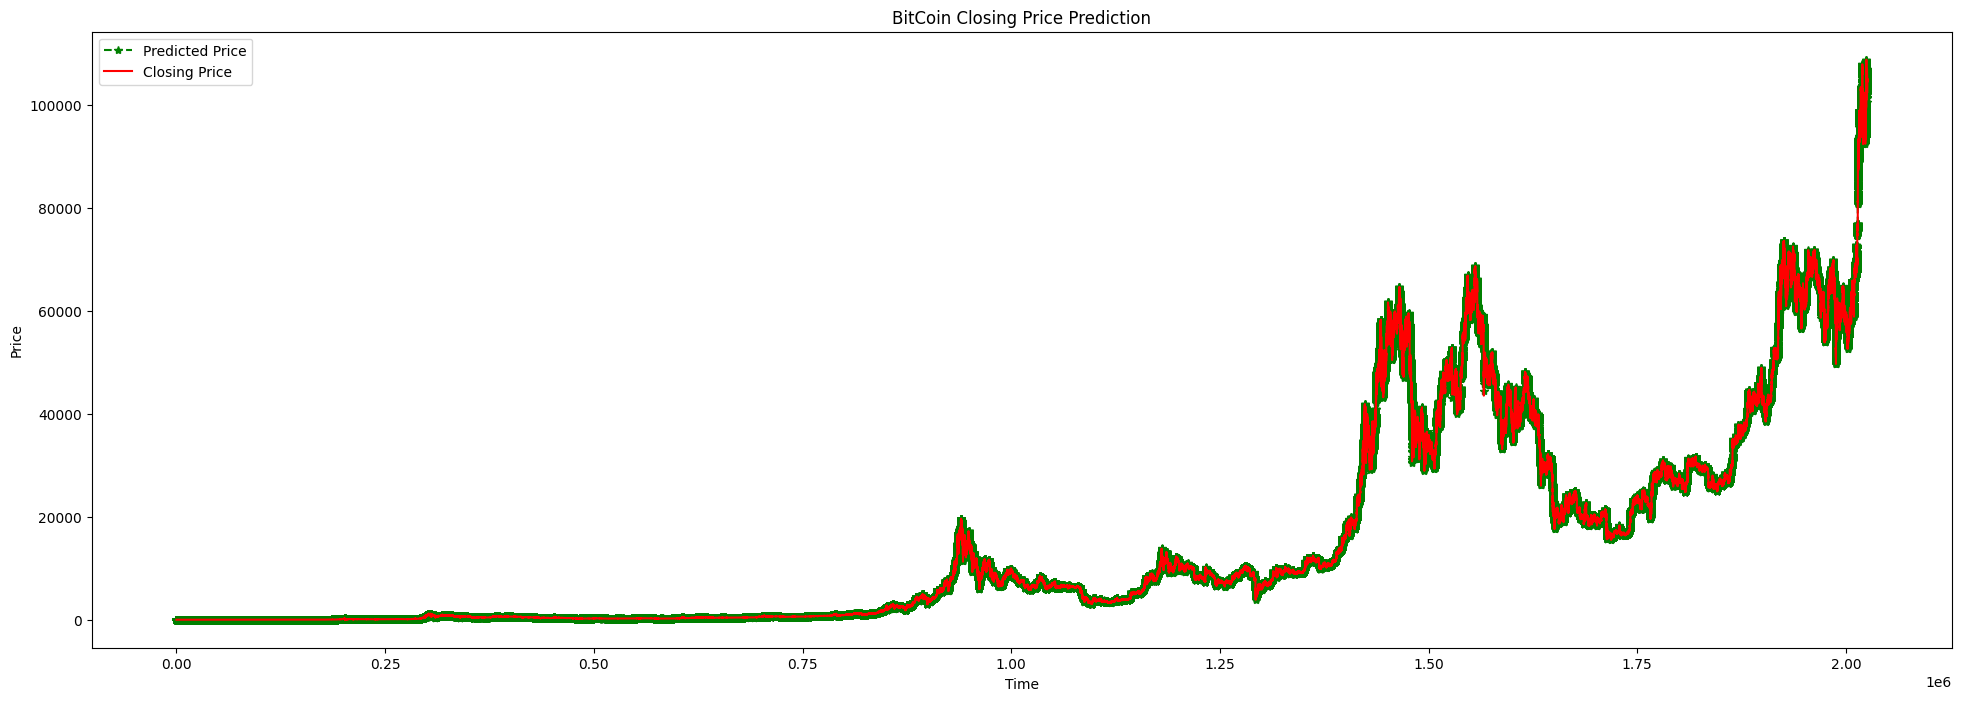

In [18]:
#Plotting Weighted_price vs Predicted_price using Matplotlib
plt.figure(figsize=(24, 8))
plt.plot(Y, color="green", marker="*", linestyle="dashed", label="Predicted Price")
plt.plot(_Y, color="red", label="Closing Price")
plt.title("BitCoin Closing Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

In [19]:
spark_session.stop()